In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)

print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
17464789/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [ ]:
from tensorflow.keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Embedding

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 39s 189ms/step - loss: 0.5998 - acc: 0.6706 - val_loss: 0.4585 - val_acc: 0.8172
Epoch 2/10
157/157 [==============================] - 21s 129ms/step - loss: 0.3644 - acc: 0.8494 - val_loss: 0.5501 - val_acc: 0.7754
Epoch 3/10
157/157 [==============================] - 15s 93ms/step - loss: 0.2846 - acc: 0.8889 - val_loss: 0.3490 - val_acc: 0.8534
Epoch 4/10
157/157 [==============================] - 12s 80ms/step - loss: 0.2344 - acc: 0.9114 - val_loss: 0.3570 - val_acc: 0.8482
Epoch 5/10
157/157 [==============================] - 12s 73ms/step - loss: 0.2109 - acc: 0.9219 - val_loss: 0.2886 - val_acc: 0.8850
Epoch 6/10
157/157 [==============================] - 9s 59ms/step - loss: 0.1871 - acc: 0.9344 - val_loss: 0.3031 - val_acc: 0.8908
Epoch 7/10
157/157 [==============================] - 8s 48ms/step - loss: 0.1673 - acc: 0.9402 - val_loss: 0.3622 - val_acc: 0.8696
Epoch 8/10
157/157 [==============================] - 7s 45ms/

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

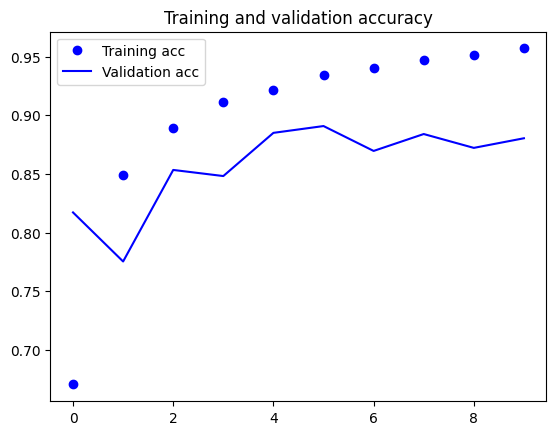

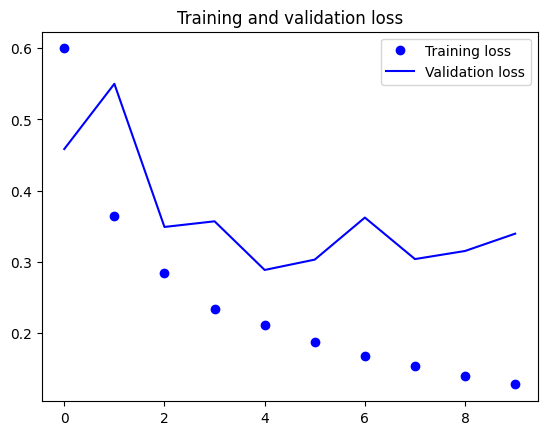

In [ ]:
plot_loss_accuracy(history)

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

--2023-10-02 08:43:05--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.166, 54.231.236.64, 52.217.15.22, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  21.0MB/s    in 0.6s    

2023-10-02 08:43:06 (21.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]



In [3]:
!unzip jena_climate_2009_2016.csv.zip

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [4]:
#Inspecting the data of the Jena weather dataset
import os

fname = '/content/jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print()
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

420451


In [5]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

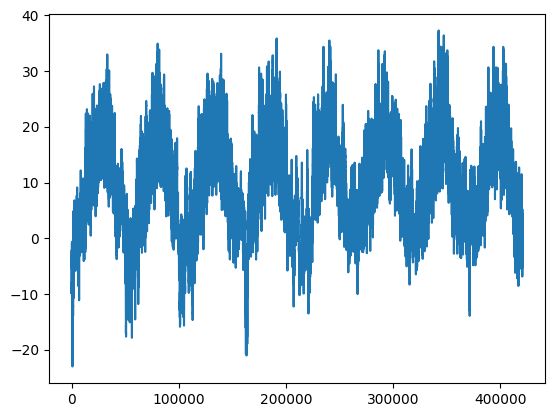

In [ ]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

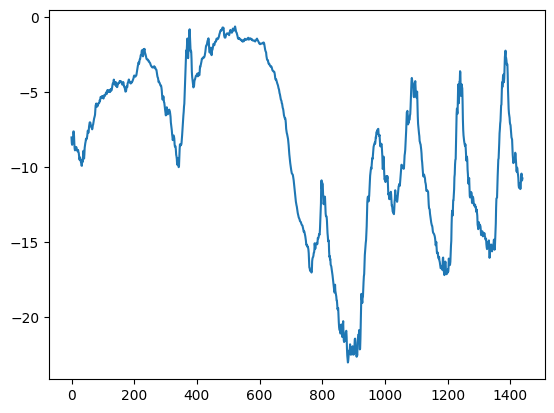

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]

        yield samples, targets

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)
val_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)
test_gen = generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size
)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.2897359729905486


In [10]:
celsius_mae = 0.29 * std[1] # [1] is the index where Celsius temperatures are stored

print(celsius_mae)

2.5672247338393395


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 12s 22ms/step - loss: 1.1550 - val_loss: 0.5625
Epoch 2/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3894 - val_loss: 0.3237
Epoch 3/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2858 - val_loss: 0.3108
Epoch 4/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2635 - val_loss: 0.3310
Epoch 5/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2519 - val_loss: 0.3110
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2418 - val_loss: 0.3102
Epoch 7/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2362 - val_loss: 0.3046
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2307 - val_loss: 0.3165
Epoch 9/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2256 - val_loss: 0.3469
Epoch 10/20
500/500 [==============================] - 13s 26ms/step - loss: 0.221

<Figure size 640x480 with 0 Axes>

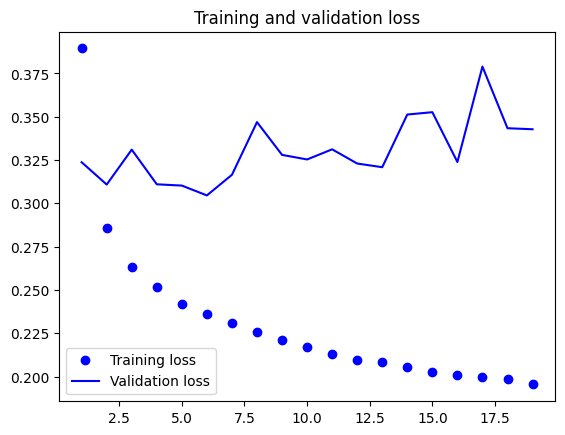

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
    plt.clf()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    # Exclude first epoch, which values are in a too high range for the curve
    plt.plot(epochs[1:], loss[1:], 'bo', label='Training loss')
    plt.plot(epochs[1:], val_loss[1:], 'b', label='Validation loss')

    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_loss_curves(history)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 16s 28ms/step - loss: 0.3050 - val_loss: 0.2693
Epoch 2/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2847 - val_loss: 0.2656
Epoch 3/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2773 - val_loss: 0.2674
Epoch 4/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2739 - val_loss: 0.2631
Epoch 5/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2713 - val_loss: 0.2657
Epoch 6/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2645 - val_loss: 0.2725
Epoch 7/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2612 - val_loss: 0.2658
Epoch 8/20
500/500 [==============================] - 14s 29ms/step - loss: 0.2589 - val_loss: 0.2726
Epoch 9/20
500/500 [==============================] - 14s 28ms/step - loss: 0.2529 - val_loss: 0.2696
Epoch 10/20
500/500 [==============================] - 15s 29ms/step - loss: 0.246

<Figure size 640x480 with 0 Axes>

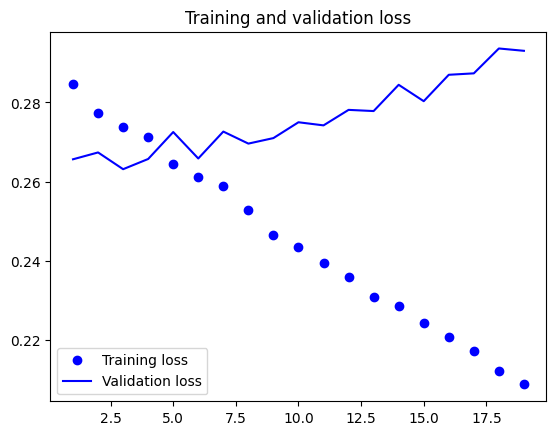

In [ ]:
plot_loss_curves(history)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32,
    dropout=0.2,
    input_shape=(None, float_data.shape[-1])
))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
500/500 [==============================] - 20s 37ms/step - loss: 0.3223 - val_loss: 0.2889
Epoch 2/40
500/500 [==============================] - 17s 33ms/step - loss: 0.3020 - val_loss: 0.2730
Epoch 3/40
500/500 [==============================] - 16s 32ms/step - loss: 0.2963 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 28s 57ms/step - loss: 0.2921 - val_loss: 0.2708
Epoch 5/40
500/500 [==============================] - 17s 35ms/step - loss: 0.2854 - val_loss: 0.2692
Epoch 6/40
500/500 [==============================] - 21s 43ms/step - loss: 0.2831 - val_loss: 0.2802
Epoch 7/40
500/500 [==============================] - 14s 28ms/step - loss: 0.2781 - val_loss: 0.2730
Epoch 8/40
500/500 [==============================] - 14s 28ms/step - loss: 0.2760 - val_loss: 0.2695
Epoch 9/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2699 - val_loss: 0.2761
Epoch 10/40
500/500 [==============================] - 14s 29ms/step - loss: 0.267

<Figure size 640x480 with 0 Axes>

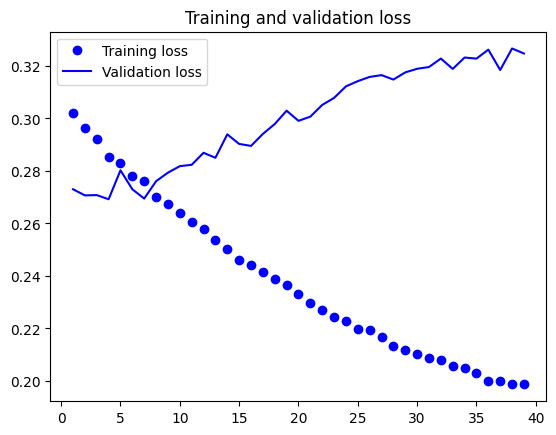

In [17]:
plot_loss_curves(history)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(
    32,
    dropout=0.1,
    return_sequences=True,
    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(
    64,
    dropout=0.1))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
500/500 [==============================] - 23s 40ms/step - loss: 0.3230 - val_loss: 0.2802
Epoch 2/40
500/500 [==============================] - 18s 37ms/step - loss: 0.2973 - val_loss: 0.2824
Epoch 3/40
500/500 [==============================] - 20s 40ms/step - loss: 0.2882 - val_loss: 0.2645
Epoch 4/40
500/500 [==============================] - 20s 40ms/step - loss: 0.2789 - val_loss: 0.2640
Epoch 5/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2705 - val_loss: 0.2682
Epoch 6/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2654 - val_loss: 0.2695
Epoch 7/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2580 - val_loss: 0.2886
Epoch 8/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2518 - val_loss: 0.2811
Epoch 9/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2419 - val_loss: 0.2766
Epoch 10/40
500/500 [==============================] - 19s 38ms/step - loss: 0.237

<Figure size 640x480 with 0 Axes>

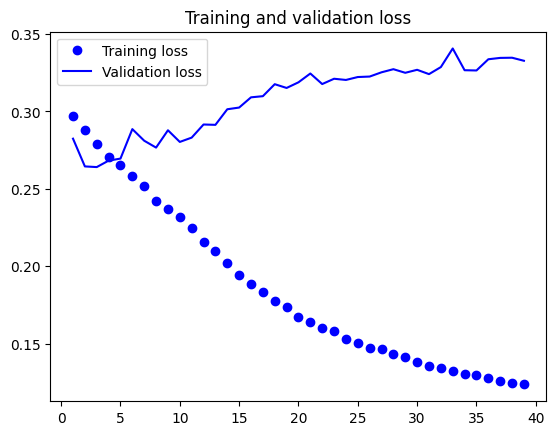

In [19]:
plot_loss_curves(history)

In [20]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets

train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size
)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size
)

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen_reverse,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen_reverse,
    validation_steps=val_steps
)

Epoch 1/20
500/500 [==============================] - 17s 30ms/step - loss: 0.4785 - val_loss: 0.4837
Epoch 2/20
500/500 [==============================] - 15s 29ms/step - loss: 0.4560 - val_loss: 0.4750
Epoch 3/20
500/500 [==============================] - 15s 29ms/step - loss: 0.4125 - val_loss: 0.4488
Epoch 4/20
500/500 [==============================] - 16s 32ms/step - loss: 0.3630 - val_loss: 0.4298
Epoch 5/20
500/500 [==============================] - 15s 29ms/step - loss: 0.3316 - val_loss: 0.4012
Epoch 6/20
500/500 [==============================] - 14s 29ms/step - loss: 0.3102 - val_loss: 0.3858
Epoch 7/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2924 - val_loss: 0.3539
Epoch 8/20
500/500 [==============================] - 15s 30ms/step - loss: 0.2809 - val_loss: 0.3647
Epoch 9/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2742 - val_loss: 0.3689
Epoch 10/20
500/500 [==============================] - 14s 29ms/step - loss: 0.264

<Figure size 640x480 with 0 Axes>

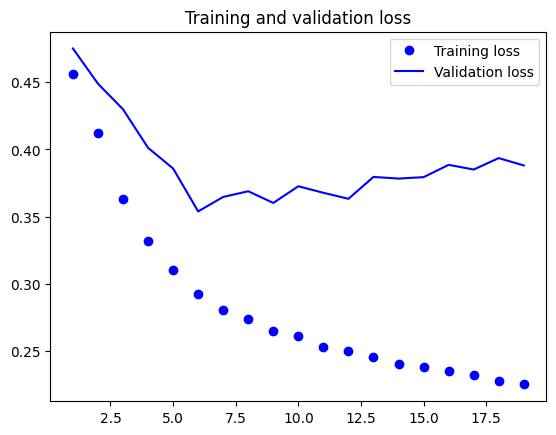

In [ ]:
plot_loss_curves(history)

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2
)

Epoch 1/10
157/157 [==============================] - 28s 166ms/step - loss: 0.6291 - acc: 0.6318 - val_loss: 0.5329 - val_acc: 0.7426
Epoch 2/10
157/157 [==============================] - 18s 115ms/step - loss: 0.4133 - acc: 0.8275 - val_loss: 0.4085 - val_acc: 0.8428
Epoch 3/10
157/157 [==============================] - 17s 112ms/step - loss: 0.3313 - acc: 0.8729 - val_loss: 0.3257 - val_acc: 0.8742
Epoch 4/10
157/157 [==============================] - 13s 85ms/step - loss: 0.2777 - acc: 0.8971 - val_loss: 0.3319 - val_acc: 0.8754
Epoch 5/10
157/157 [==============================] - 11s 73ms/step - loss: 0.2437 - acc: 0.9135 - val_loss: 0.3437 - val_acc: 0.8656
Epoch 6/10
157/157 [==============================] - 7s 46ms/step - loss: 0.2186 - acc: 0.9222 - val_loss: 0.3851 - val_acc: 0.8738
Epoch 7/10
157/157 [==============================] - 8s 52ms/step - loss: 0.1979 - acc: 0.9324 - val_loss: 0.3546 - val_acc: 0.8820
Epoch 8/10
157/157 [==============================] - 6s 39ms

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 26s 145ms/step - loss: 0.6705 - acc: 0.5724 - val_loss: 0.5541 - val_acc: 0.7442
Epoch 2/10
157/157 [==============================] - 15s 98ms/step - loss: 0.4674 - acc: 0.8016 - val_loss: 0.3700 - val_acc: 0.8536
Epoch 3/10
157/157 [==============================] - 16s 100ms/step - loss: 0.3319 - acc: 0.8716 - val_loss: 0.3809 - val_acc: 0.8630
Epoch 4/10
157/157 [==============================] - 12s 77ms/step - loss: 0.2815 - acc: 0.8954 - val_loss: 0.3716 - val_acc: 0.8596
Epoch 5/10
157/157 [==============================] - 11s 68ms/step - loss: 0.2443 - acc: 0.9121 - val_loss: 0.3455 - val_acc: 0.8600
Epoch 6/10
157/157 [==============================] - 9s 60ms/step - loss: 0.2196 - acc: 0.9204 - val_loss: 0.3142 - val_acc: 0.8838
Epoch 7/10
157/157 [==============================] - 9s 56ms/step - loss: 0.1912 - acc: 0.9327 - val_loss: 0.3607 - val_acc: 0.8434
Epoch 8/10
157/157 [==============================] - 9s 56ms/

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps
)

Epoch 1/40
500/500 [==============================] - 40s 56ms/step - loss: 0.3010 - val_loss: 0.2844
Epoch 2/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2765 - val_loss: 0.2647
Epoch 3/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2696 - val_loss: 0.2673
Epoch 4/40
500/500 [==============================] - 18s 37ms/step - loss: 0.2642 - val_loss: 0.2751
Epoch 5/40
500/500 [==============================] - 20s 39ms/step - loss: 0.2597 - val_loss: 0.2694
Epoch 6/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2546 - val_loss: 0.2695
Epoch 7/40
500/500 [==============================] - 19s 37ms/step - loss: 0.2501 - val_loss: 0.2711
Epoch 8/40
500/500 [==============================] - 19s 38ms/step - loss: 0.2450 - val_loss: 0.2750
Epoch 9/40
500/500 [==============================] - 18s 36ms/step - loss: 0.2406 - val_loss: 0.2812
Epoch 10/40
500/500 [==============================] - 18s 37ms/step - loss: 0.233

<Figure size 640x480 with 0 Axes>

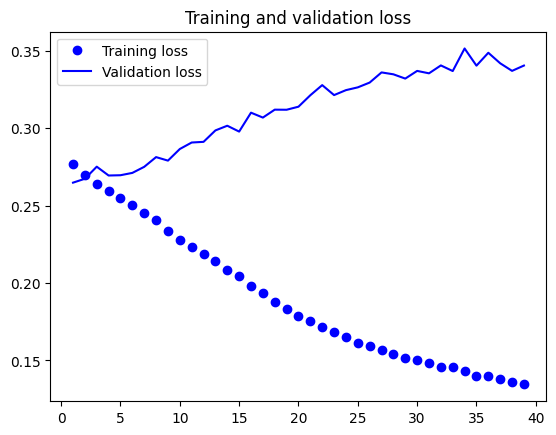

In [ ]:
plot_loss_curves(history)